In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
import segyio
from scipy import signal
from scipy import fftpack
from scipy import linalg

In [28]:
from ukpgks import segy
from ukpgks import plots
from ukpgks import signal as usignal

(6251, 800) (6251,)


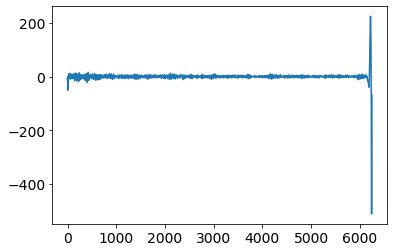

In [29]:
data,hdr = segy.read_segy('8_obs_80km.segy') # raw data
d_r,hdr = segy.read_segy('8_obs_80km_d.segy') # raw data + decon to QC results
data = usignal.resample(data.T,0.010,0.004)
d = data[:,5]
plt.plot(d)
print (data.shape,d.shape)

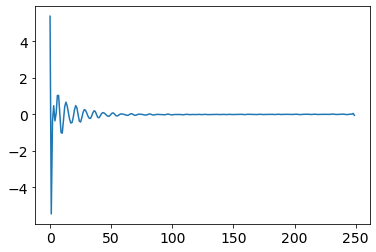

In [30]:
nop,nlag,stab = 250,6,0.0001
a = auto(d,nop+nlag,0)
f = predict(d,nop,nlag,stab)
plt.plot(f)

In [31]:
dt = 0.004
tgap=0.024 # prediction gap (seconds)
td=1.0  #operator length (seconds)
stab=0.0001 #stability constant
n=round(td/dt) # operator length in samples
ngap=round(tgap/dt) #prediction gap in samples
# stab=0.0001;%stability constant
decon_data,x = decon(data,data,n,ngap,stab)

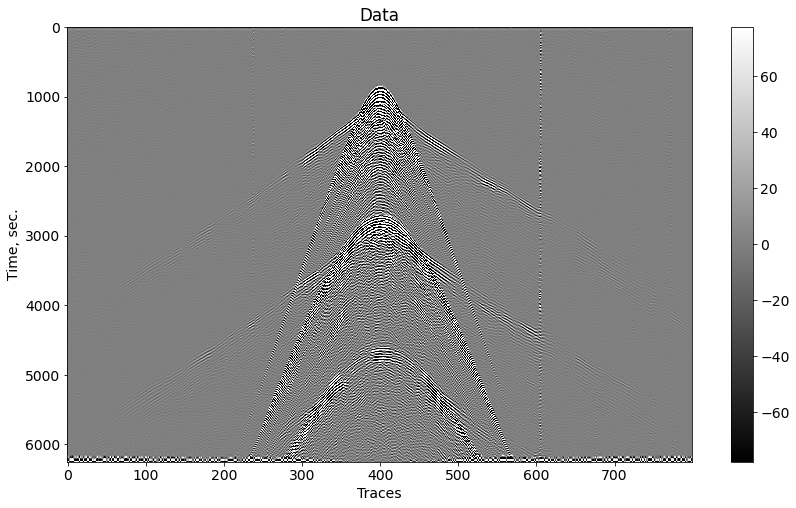

In [33]:
plots.plot2D_shot(data.T,size=(14,8))

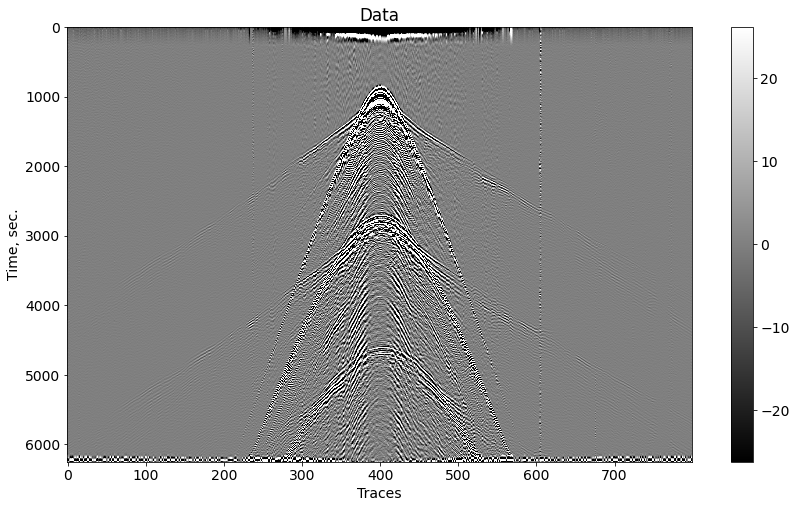

In [34]:
plots.plot2D_shot(decon_data.T,size=(14,8))

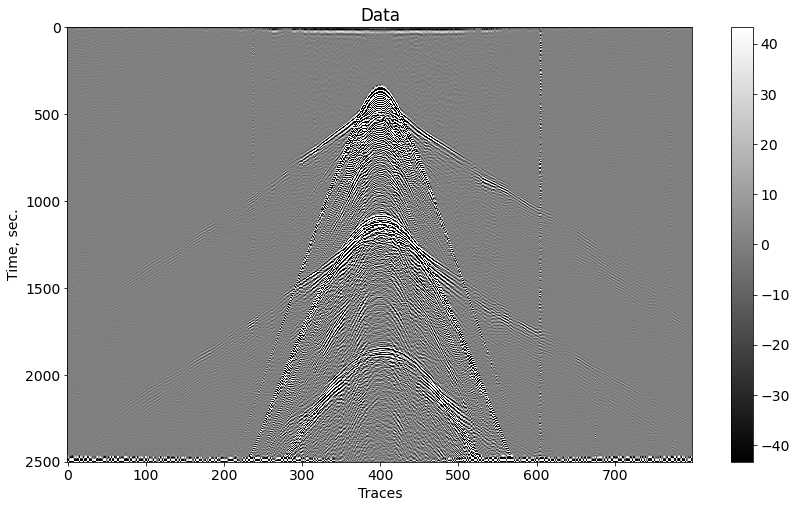

In [36]:
plots.plot2D_shot(d_r,size=(14,8))

In [22]:
import time

t0 = time.time()
# x   = solve_toeplitz(aa,bb)
# # # xx  = np.linalg.solve(T,bb)
# # xxx = solve(T,b)
# a = np.convolve(d,d)
a = signal.convolve(d,d)
t1 = time.time()

total = t1-t0
total
a.shape

(12501,)

In [25]:
def decon(datain,datadsign,nop,nlag,stab):
    """
    DECON performs Wiener predictive deconvolution by calling PREDICT to design a prediction filter,
    nop long with lag nlag and stab factor, using trdsign. The predicted part of datain (trinpr) is
    formed by convolving the prediction operator with datain. 
    The output trace, dataout, is computed by delaying trinpr by nlag samples and subtracting it from datain. 
    The prediction operator is returned in x.
    
    inputs:
    datain= input trace to be deconvolved
    tdatadsign= input trace used to design the prediction operator
    nop= number of points in the prediction operator
    nlag= prediction lag distance in samples
    stab= stabilazation factor expressed as a fraction of the zero lag of the autocorrelation.
    default= .0001 
    
    outputs:
    trout= deconvolved output trace
    x= prediction operator

    if datain is a matrix, then each column is deconvolved and datadsign
    must have the same number of columns as datain.
    """
    nt,ntr = datain.shape
    dataout = np.zeros_like(data)
    nop = nop * np.ones(ntr,dtype='int')
    nlag= ngap* np.ones(ntr,dtype='int')
    stab = stab * np.ones(ntr)
    
    for k in range(ntr):
        x = predict(datadsign[:,k],nop[k],nlag[k],stab[k]) # solves with scipy.linilg.solve_toeplitz
        trinpr = signal.convolve(datain[:,k],x)
        # delay and subtract
        tmp = data[nlag[k]:nt,k] - trinpr[0:nt-nlag[k]]
        dataout[:,k] = np.hstack([data[0:nlag[k],k],tmp])
    return dataout,x

In [23]:
def predict(data,nop,nlag=1,stab=0.0001):
    """ Returns the nop long Wiener prediction filter for a  
    lag of nlag time samples. The filter is designed on the input
    trace, trin, and a stab factor is included by multiplying the 
    zero lag of the normalized autocorrelation by 1+stab.
    load from scipy.linalg import solve_toeplitz
    
    trin (seism trace)                        = input trace used to design the prediction operator
    nop    (operator length / dt in samples)  = number of points in the prediction operator
    nlag  (prediction gap / dt  in samples)   = prediction lag distance in samples
    stab                                      = stability constant
    """
    
    a = auto(data,nop+nlag,0)
    a[0,0] = a[0,0] * (1 + stab)
    a = a / a[0,0]
    b = a[0,nlag:nlag+nop]
    a = a[0,:nop]
    #print (a.shape,b.shape)
    predic_filt = linalg.solve_toeplitz(a,b)
    return predic_filt

In [24]:
def auto(v,n=None,flag=1):
    """ single-sided autocorrelation
    a=auto(v,n,flag) , a=auto(v,n) , a=auto(v)
    
    Computes n lags of the one sided autocorrelation of 
    array. The first lag, a(1), is termed the 'zeroth lag'
    inputs:
    v = input numpy array
    n = number of lags desired (can be no larger than length(v)), default =length(v)
    flag= 1.0 normalize the 'zero lag' (first returned value) to 1.0.
    anything else don't normalize, default =1.0 ******
    outputs:
    a = one sided autocorrelation returned as a row vvector. a(1) is zero lag.
    """
    if n == None:
        n = len(v)
        
    a =np.zeros((1,n))
    
    
    v = v.reshape(-1,1) # make row vector (n,1)
    u = np.copy(v.reshape(1,-1)) # make column vector (1,n)
    
    for i in range(n):
        a[0,i] = u@v
        u = np.roll(u,1)
        u[0,0] = 0
        
    if flag == 1:
        a = a  / np.max(a)
        return a
    elif flag !=1:
        return a